## Distribuição Territorial da População

**AUTORIA:** [REDE MOB](https://www.redemob.com.br/)

Este script constrói mapas básicos da área de estudo. Especificamente, serão consolidadas e apresentadas as distribuições territoriais de variáveis demográficas e socioeconômicas de interesse. Adicionalmente, há o complemento de atributos territoriais que entende-se que são, também, variáveis explicativas. Especificamente, o foco estará, preliminarmente, nas seguintes variáveis, as quais serão elaboradas em maior profundidade mais à frente.

- Contagens populacionais
- Rendimentos médios

**PANORAMA:**
- Faz a leitura dos dados do Censo Demográfico: população segundo idade e rendimento
- Produz mapas e gráficos descritivos.


**MAIS INFORMAÇÕES:**
- [Layout da Plataforma]
- [Sumário dos Dados Disponíveis]
- *Lorem ipsum: Conteúdo do MOB de interesse, técnico ou de divulgação*

**LINKS DE INTERESSE:**
- links para materiais técnicos e acadêmicos gerais, externos, de referência a respeito do conteúdo abordado


# Instruções

Este script requer:
1. O código do IBGE para o município
    - Caso se deseje fazer a análise de municípios vizinhos, fornecer uma lista com os códigos do IBGE destes municípios
2. Ano da análise: permite avaliar, alternativamente, dados do Censo de 2010 ou de 2022
    - Para 2022, o Censo apenas liberou dados de rendimento do responsável [até o momento](https://www.ibge.gov.br/novo-portal-destaques/42982-ibge-divulgara-em-30-de-abril-informacoes-do-censo-demografico-2022-sobre-o-rendimento-do-responsavel-pelo-domicilio.html). Com efeito, **não é possível calcular indicadores, como taxa de pobreza e índice de Gini, ou efetuar ranqueamento de divisões territoriais, de acordo com o rendimento**. No entanto, mantivemos a construção de um mapa de população classificado por cores de acordo com o rendimento dos responsáveis por domicílios, pois entendemos que há valor na informação, mas as observações acima devem estar em mente.
  
2. [Chave referente a um projeto no Google Cloud](https://basedosdados.org/docs/access_data_bq)

# Parâmetros Definidos Pelo Usuário

In [1]:
# Backend preliminar
from getpass import getpass

In [2]:
# Forneça código do IBGE da cidade, ou lista de códigos
# se quiser cidades vizinhas. P. ex.:
# ibge_id = 3303302 -> Niterói
ibge_id = [3303302, 3304904, 3301900] # Niterói, São Gonçalo, Itaboraí

ano = 2022

# Chave de API do Google Cloud Platform
gcloud_id = getpass("Chave de API do Google Cloud Platform: ")
    

# Backend

## Bibliotecas e Parâmetros Básicos

In [32]:
from io import BytesIO
from pathlib import Path
import re
import requests
import tempfile
import zipfile

import contextily as ctx
import basedosdados as bd
import geobr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from matplotlib_map_utils.core.north_arrow import north_arrow
from matplotlib_scalebar.scalebar import ScaleBar
import mapclassify
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.affinity import scale
from statsmodels.stats.weightstats import DescrStatsW
from tobler.area_weighted import area_interpolate
from tobler.util import h3fy


In [56]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')

In [5]:
pd.options.display.float_format = '{:,.2f}'.format

# Os Atributos Territoriais

Resgatando o que foi dito no preâmbulo deste script, estamos interessados nas seguintes variáveis:
1. Contagens populacionais
2. Contagem de domicílios
3. Rendimentos médios

A ideia, portanto, é fazer a leitura e o ajuste dessas variáveis para que possam ser imptuadas nas malhas hexagonais H3.

Deve-se salientar que para 2022, os dados de rendimento médio por setor censitário não estão disponíveis e, por ora, apenas há possibilidade de mapear os rendimentos dos responsáveis pelos domicílios. Embora isso revele insights interessantes, como já dito,**não é possível calcular indicadores, como taxa de pobreza e índice de Gini, ou efetuar ranqueamento de divisões territoriais, de acordo com o rendimento**.

In [6]:
def get_census_tracts(ibge_id, year=2022) -> gpd.GeoDataFrame:
    """
    Prepares the study area by fetching census tracts for the given IBGE IDs.

    Parameters:
        ibge_id (int or list[int]): IBGE municipality code(s).
        year (int): Year of the census data (default is 2022).

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame with census tracts, properly formatted.
    """
    if not isinstance(ibge_id, list):
        ibge_id = [ibge_id]

    # Fetch census tracts for each IBGE ID
    tracts = pd.concat(
        [geobr.read_census_tract(int(id_), year=year) for id_ in ibge_id]
    )
    crs = tracts.estimate_utm_crs(datum_name='SIRGAS 2000')

    # Process and format the GeoDataFrame
    tracts = (
        tracts.astype({'code_tract': np.int64})
        .astype({'code_tract': 'str'})
        .rename(columns={'code_tract': 'id_setor_censitario'})
        .set_index('id_setor_censitario')
        .to_crs(crs)
    )

    return tracts

In [7]:
def import_census_data(year, ibge_id, gcloud_id=None) -> gpd.GeoDataFrame:
    """
    Imports census data for the specified year (2010 or 2022).

    Parameters:
        year (int): The year of the census data (2010 or 2022).
        ibge_id (int, str, iterable): The IBGE municipality codes.
        gcloud_id (str): Google Cloud billing project ID (required for 2010).

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing census data with geometry.
    """
    tracts = get_census_tracts(ibge_id, year=year)

    if year == 2010:
        return _import_census_2010(tracts, gcloud_id)
    elif year == 2022:
        return _import_census_2022(tracts, gcloud_id)
    else:
        raise ValueError("Invalid year. Only 2010 and 2022 are supported.")


def _import_census_2010(tracts: gpd.GeoDataFrame, gcloud_id: str) -> pd.DataFrame:
    """
    Imports census data for 2010.

    Parameters:
        gcloud_id (str): Google Cloud billing project ID.

    Returns:
        pd.DataFrame: A DataFrame containing census data for 2010.
    """
    query = (
        "SELECT id_setor_censitario, v009, v002, v001 "
        "FROM basedosdados.br_ibge_censo_demografico.setor_censitario_basico_2010 "
        f"WHERE id_setor_censitario IN ({_sql_style_list(tracts.index)})"
    )

    data = bd.read_sql(query, billing_project_id=gcloud_id)

    data = (
        data
        .astype({"id_setor_censitario": str})
        .rename(
            columns={
                "v009": "rendimento_medio",
                "v002": "habitantes",
                "v001": "domicilios",
            }
        )
    )
    return (
        tracts
        .reindex(columns=['geometry'])
        .merge(
            data,
            how="left",
            left_index=True,
            right_on="id_setor_censitario",
        )
    )


def _import_census_2022(tracts: gpd.GeoDataFrame, gcloud_id: str) -> gpd.GeoDataFrame:
    """
    Imports census data for 2022.

    Parameters:
        tracts (gpd.GeoDataFrame): A GeoDataFrame containing the tracts data.
        gcloud_id (str): Google Cloud billing project ID.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing census data for 2022.
    """
    query = (
        "SELECT id_setor_censitario, pessoas, domicilios, geometria "
        "FROM basedosdados.br_ibge_censo_2022.setor_censitario "
        f"WHERE id_setor_censitario IN ({_sql_style_list(tracts.index)}) "
    )

    data = bd.read_sql(query, billing_project_id=gcloud_id)

    data = gpd.GeoDataFrame(
        data,
        geometry=gpd.GeoSeries.from_wkt(data["geometria"]),
        crs=4326,
    ).drop(columns="geometria").to_crs(31983)

    income_data = get_income_head_household_data()
    return data.merge(
        income_data,
        how="left",
        left_on="id_setor_censitario",
        right_on="id_setor_censitario",
    ).rename(
        columns={'pessoas': 'habitantes'}
    )


def _sql_style_list(sequence):
    """
    Converts a list of values into a SQL-style list of single-quoted strings.
    """
    return ", ".join(f"'{item}'" for item in sequence)


def get_income_head_household_data() -> pd.DataFrame:
    """
    Downloads and processes income data for household heads from the IBGE link.

    Returns:
        pd.DataFrame: A DataFrame with columns 'id_setor_censitario' and
                      'rendimento_medio'.
    """
    url = (
        "https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/"
        "Agregados_por_Setores_Censitarios_Rendimento_do_Responsavel/"
        "Agregados_por_setores_renda_responsavel_BR_csv.zip"
    )
    print(f"Downloading income data from: {url}")

    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(
            f"Failed to download data. HTTP Status Code: {response.status_code}"
        )

    with zipfile.ZipFile(BytesIO(response.content)) as zf:
        # Search for the CSV file, even if it's in a subdirectory
        csv_file_name = next(
            (name for name in zf.namelist() if name.endswith(".csv")), None
        )
        if not csv_file_name:
            raise FileNotFoundError("No CSV file found in the ZIP archive.")

        with zf.open(csv_file_name) as csv_file:
            income_data = pd.read_csv(csv_file, sep=";", encoding="latin1")

    return (
        income_data
        .rename(
            columns={
                "CD_SETOR": "id_setor_censitario",
                "V06004": "rendimento_medio",
            }
        )
        .reindex(columns=["id_setor_censitario", "rendimento_medio"])
        .astype({"id_setor_censitario": str})
        .replace({"rendimento_medio": {"X": None}})
        .pipe(
            lambda df: df.assign(
                rendimento_medio=(
                    df["rendimento_medio"]
                    .str.replace(",", ".", regex=False)
                    .replace(r"^\.$", None, regex=True)
                    .astype(float)
                )
            )
        )
    )

In [8]:
def get_urban_area_gdf(year: int) -> gpd.GeoDataFrame:
    """
    Given a year (2005, 2015, 2019), download the corresponding ZIP file from IBGE,
    extract the shapefile (even if it's in a subdirectory), and return it as a GeoDataFrame.
    """
    base = (
        "https://geoftp.ibge.gov.br/organizacao_do_territorio/"
        "tipologias_do_territorio/areas_urbanizadas_do_brasil"
    )

    mapping = {
        2005: f"{base}/2005/areas_urbanizadas_do_Brasil_2005_shapes.zip",
        2015: f"{base}/2015/Shapes/AreasUrbanizadasDoBrasil.zip",
        2019: f"{base}/2019/Shapefile/AreasUrbanizadas2019_Brasil.zip",  # confirmed same ZIP name
    }

    closest_key = min(mapping, key=lambda x:abs(x-year))
    #url = mapping[closest_key]
    url = mapping[2019]  # Use the 2019 URL directly for testing
    print(f"Downloading: {url}")
    
    # Stream and extract the ZIP
    response = requests.get(url)
    with zipfile.ZipFile(BytesIO(response.content)) as zf:
        # Create a temporary directory to extract the shapefile
        with tempfile.TemporaryDirectory() as tmpdir:
            tmpdir_path = Path(tmpdir)
            zf.extractall(tmpdir_path)  # Extract all files to the temp directory
            
            # Search for the .shp file recursively
            shp_path = next(tmpdir_path.rglob("*.shp"), None)
            
            if not shp_path:
                raise FileNotFoundError("No .shp file found in the extracted ZIP archive.")
            
            # Read the shapefile using geopandas
            gdf = gpd.read_file(shp_path)

    return gdf

In [9]:
def generate_hexes(tracts, footprint, resolution):
    """
    Generates hexagonal grids (H3) for the given tracts and footprint.

    Parameters:
        tracts (gpd.GeoDataFrame): GeoDataFrame of census tracts.
        footprint (gpd.GeoDataFrame): GeoDataFrame of urban areas.
        resolution (int): H3 resolution level (default is 9).

    Returns:
        gpd.GeoDataFrame: GeoDataFrame of hexagonal grids with spatial join.
    """
    hexes = (
        h3fy(tracts, resolution=resolution)
        .reset_index()
        .sjoin(
            footprint
            .reindex(columns=["geometry"])
            .to_crs(tracts.crs)
            )
        .drop(columns="index_right")
        .drop_duplicates(subset="hex_id")
        .set_index("hex_id")
    )
    return hexes

In [10]:
def interpolate_data_to_hexes(tracts_with_data, hexes):
    """
    Interpolates census data from tracts to hexagonal grids.

    Parameters:
        tracts_with_data (gpd.GeoDataFrame): GeoDataFrame containing census 
            tracts with data.
        hexes (gpd.GeoDataFrame): GeoDataFrame containing hexagonal grids.

    Returns:
        gpd.GeoDataFrame: GeoDataFrame with interpolated data joined to 
            hexagonal grids.
    """
    interpolated_data = area_interpolate(
        source_df=tracts_with_data.assign(geometry=lambda x: x.buffer(0)),
        target_df=hexes,
        extensive_variables=['habitantes', 'domicilios'],
        intensive_variables=['rendimento_medio']
    ).drop(columns='geometry')

    return pd.merge(
        hexes,
        interpolated_data.set_index(hexes.index),
        left_index=True,
        right_index=True
    )

In [11]:
def get_study_area(ibge_id, gcloud_id, year=2022, resolution=9) -> gpd.GeoDataFrame:
    """
    Prepares the study area by fetching census tracts for the given IBGE IDs.

    Parameters:
        ibge_id (int or list[int]): IBGE municipality code(s).
        year (int): Year of the census data (default is 2022).
        gcloud_id (str): Google Cloud billing project ID.
        resolution (int): H3 resolution level (default is 9).

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame with census tracts, properly formatted.
    """
    if not gcloud_id:
        raise ValueError(
            "Google Cloud billing project ID (gcloud_id) is required!"
        )

    # Fetch census tracts for each IBGE ID
    tracts = import_census_data(year, ibge_id, gcloud_id)
    footprint = get_urban_area_gdf(year)
    hexes = generate_hexes(tracts, footprint, resolution)
    interpolated_data = interpolate_data_to_hexes(tracts, hexes)

    return interpolated_data

In [12]:
hexes = get_study_area(ibge_id, gcloud_id, year=ano)

Downloading: 100%|██████████|
Downloading: https://geoftp.ibge.gov.br/organizacao_do_territorio/tipologias_do_territorio/areas_urbanizadas_do_brasil/2019/Shapefile/AreasUrbanizadas2019_Brasil.zip


In [13]:
output_dir = Path().cwd().parent / 'database/1. Socioeconômicos'
output_dir.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
output_path = output_dir / f'sociodemografia_{ano}.parquet'

hexes.to_parquet(output_path, compression='brotli')

# Visualizações

In [14]:
def classify_income_deciles(
        df,
        income_col='rendimento_medio',
        weight_col='habitantes',
        ):
    """
    Classifies each row into population-weighted income deciles using statsmodels.
    
    Parameters:
        df: pd.DataFrame
        income_col: str - column name with income
        weight_col: str - column name with population weights
    
    Returns:
        pd.Series with decile labels (1–10)
    """
    d = DescrStatsW(df[income_col], weights=df[weight_col])
    # Compute the quantile breakpoints for deciles
    quantiles = [d.quantile(q) for q in np.linspace(0.1, 1.0, 10)]
    bins = [df[income_col].min() - 1] + [float(q) for q in quantiles]
    
    # Assign decile labels 1–10
    return pd.cut(df[income_col], bins=bins, labels=range(1, 11), include_lowest=True)

In [15]:
def plot_socioeconomic_data(
    hexagons: gpd.GeoDataFrame,
    income_col: str,
    population_column: str,
    income_as_decile: bool = True,
    income_scheme: str = "quantiles",
    population_scheme: str = "FisherJenks",
    cmap: str = "RdBu",
    dpi: int = 600,
    output_file: str = None,
):
    """
    Plot hexagons scaled by population and colored by smoothed income.

    Parameters:
        hex_gdf (GeoDataFrame): GeoDataFrame with hexagonal cells.
        income_metric (str): Base name of income column (e.g., 'income').
        population_column (str): Name of population column.
        income_scheme (str): Color classification scheme (e.g., 'quantiles').
        cmap (str): Matplotlib colormap (e.g., 'RdBu').
        dpi (int): Resolution for saved image.
        output_file (str): File path to save image (optional).
    """
    validate_column_exists(hexagons, income_col)
    validate_column_exists(hexagons, population_column)

    hex_gdf = hexagons.query('habitantes > 1')
    if income_as_decile:
        hex_gdf['decil_renda'] = classify_income_deciles(hex_gdf)
        income_col = 'decil_renda'
        income_scheme = None

    fig, ax = setup_plot(hex_gdf)
    plot_hexagons_scaled_by_population(
        hex_gdf, income_col, population_column, income_scheme,
        cmap, ax, population_scheme,
        )
    add_basemap(ax, hex_gdf)
    north_arrow(
        ax, location="upper left", rotation={"crs": hex_gdf.crs, "reference": "center"}
    )
    add_population_legend(ax)
    add_scalebar(ax)
    add_annotations(ax)
    finalize_plot(fig, ax, dpi, output_file)


def plot_hexagons_scaled_by_population(
    hex_gdf, income_col, pop_col, income_scheme, cmap, ax, population_scheme,
):
    """
    Draw hexagons resized by population bin and colored by income.
    """
    values = hex_gdf[pop_col].fillna(0)
   
    classifier_cls = getattr(mapclassify, population_scheme)
    try:
        classifier = classifier_cls(values, k=5)
    except:
        classifier = classifier_cls(values)

    bins = classifier.bins
    bins = np.concatenate([[values.min()], bins])
    
    scales, _ = compute_population_scales_and_labels(bins)
    hex_gdf["_scale"] = pd.cut(
        values, bins=bins, labels=scales, include_lowest=True
    ).astype(float)

    scaled_geom = [
        scale(geom, xfact=s, yfact=s, origin=geom.centroid)
        for geom, s in zip(hex_gdf.geometry, hex_gdf["_scale"])
    ]

    gdf_scaled = gpd.GeoDataFrame(
        hex_gdf[[income_col]].copy(),
        geometry=scaled_geom,
        crs=hex_gdf.crs
    )

    gdf_scaled.plot(
        column=income_col,
        cmap=cmap,
        scheme=income_scheme,
        legend=True,
        edgecolor="none",
        ax=ax,
        legend_kwds={
            "fontsize": 12,
            "title": "Decil de Renda",
            "title_fontsize": 14,
            "frameon": True,  # Enable the frame
            "facecolor": "white",  # Set the frame background color to white
        }
    )
    ax._cached_population_bins = bins


def compute_population_scales_and_labels(bins, scale_min=0.4, scale_max=1.0):
    """
    Given a list of bin edges, compute visual scaling factors and label strings.

    Parameters:
        bins (array-like): Bin edges (length = n_bins + 1)
        scale_min (float): Minimum visual scale factor
        scale_max (float): Maximum visual scale factor

    Returns:
        scales (List[float]): Scaling factors (length = len(bins) - 1)
        labels (List[str]): Formatted bin labels
    """
    n_bins = len(bins) - 1
    scales = np.linspace(scale_min, scale_max, n_bins)
    labels = [
        f"{int(bins[i]):,} – {int(bins[i + 1]):,}"
        for i in range(n_bins)
    ]
    return scales, labels
    

def validate_column_exists(gdf, column):
    if column not in gdf.columns:
        raise ValueError(f"Column '{column}' not found in GeoDataFrame.")


def setup_plot(gdf):
    a4_width = 11.7
    bounds = gdf.total_bounds
    aspect = (bounds[3] - bounds[1]) / (bounds[2] - bounds[0])
    height = a4_width * aspect
    fig, ax = plt.subplots(figsize=(a4_width, height))
    return fig, ax


def add_basemap(ax, gdf):
    ctx.add_basemap(
        ax,
        crs=gdf.crs,
        source=ctx.providers.CartoDB.PositronNoLabels,
    )


def add_scalebar(ax):
    scalebar = ScaleBar(
        dx=1,
        units="m",
        location="lower right",
        scale_loc="bottom",
        box_alpha=0.5
    )
    ax.add_artist(scalebar)


def add_north_arrow(ax):
    ax.annotate(
        "N",
        xy=(0.975, 0.975),
        xytext=(0.975, 0.85),
        arrowprops=dict(
            facecolor="black",
            width=5,
            headwidth=15
        ),
        ha="center",
        va="center",
        fontsize=20,
        xycoords="axes fraction"
    )


def add_scalebar(ax):
    """
    Adds a scalebar to the plot.

    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The Matplotlib axis.
    """
    scalebar = ScaleBar(
        dx=1,
        units="m",
        location="lower right",
        scale_loc="bottom",
        box_alpha=0.5,
    )
    ax.add_artist(scalebar)


def finalize_plot(fig, ax, dpi, output_file):
    ax.axis("off")
    if output_file:
        plt.savefig(output_file, dpi=dpi, bbox_inches="tight")
        plt.show()
    else:
        plt.show()
    plt.close(fig)


def add_population_legend(ax, loc="lower right", bbox_to_anchor=(0.995, 0.05)):
    """
    Add a hex size legend using hexagonal markers of varying size.
    """
    bins = getattr(ax, "_cached_population_bins", None)
    scales, labels = compute_population_scales_and_labels(bins)

    # Scale marker size linearly (you may want to fine-tune factor)
    size_factor = 10  # Adjust for visual match
    handles = [
        Line2D(
            [], [],
            marker="h",  # or 'H' for filled hexagon
            color="black",
            linestyle="None",
            markersize=scale * size_factor,
            markerfacecolor="black",
            markeredgewidth=0,
            linewidth=0,
        )
        for scale in scales
    ]

    legend2 = Legend(
        ax,
        handles,
        labels,
        loc=loc,
        bbox_to_anchor=bbox_to_anchor,
        frameon=True,
        fontsize=12,
        title="População Total",
        labelspacing=1.25,
        title_fontsize=14,
        facecolor='white',
    )

    ax.add_artist(legend2)


def _get_places_to_plot():
    muni_by_neighborhood = {
        'Icaraí': 'Niterói',
        'Estrela Do Norte': 'São Gonçalo',
        'Alcântara': 'Alcântara (São Gonçalo)',
        'Itaboraí': 'Itaboraí',
        'Manilha': 'Manilha (Itaboraí)'
    }

    return (
        geobr
        .read_neighborhood()
        .to_crs(31983)
        .query("abbrev_state == 'RJ'")
        .query("name_neighborhood.isin(@muni_by_neighborhood)")
        .replace({'name_neighborhood': muni_by_neighborhood})
        .set_index('name_neighborhood')
        .centroid
        .to_dict()
        )


def add_annotations(ax):
    """
    Add annotations with arrows pointing to municipal seats and Alcântara.

    Parameters:
        ax (matplotlib.axes.Axes): The Matplotlib axis to add annotations to.
        crs (pyproj.CRS or str): The target CRS (e.g., EPSG:31983).
    """
    places = _get_places_to_plot()
    
    # Transform coordinates to the target CRS
    offset = -7000
    for name, coords in places.items():
        x, y = coords.x, coords.y
        ax.annotate(
            name,
            xy=(x, y),  # Coordinates
            xytext=(x, y + offset),  # Offset for text (adjust as needed)
            ha='center',
            arrowprops=dict(
                #arrowstyle="->",
                linewidth=.5,  # Make the arrow thicker
                color="black",
                ),
            fontsize=12,
            color="black",
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        )

        offset *= -1
    



In [16]:
outpath = Path(
    f"../outputs/mapas/sociodemografia_{ano}.png"
    )

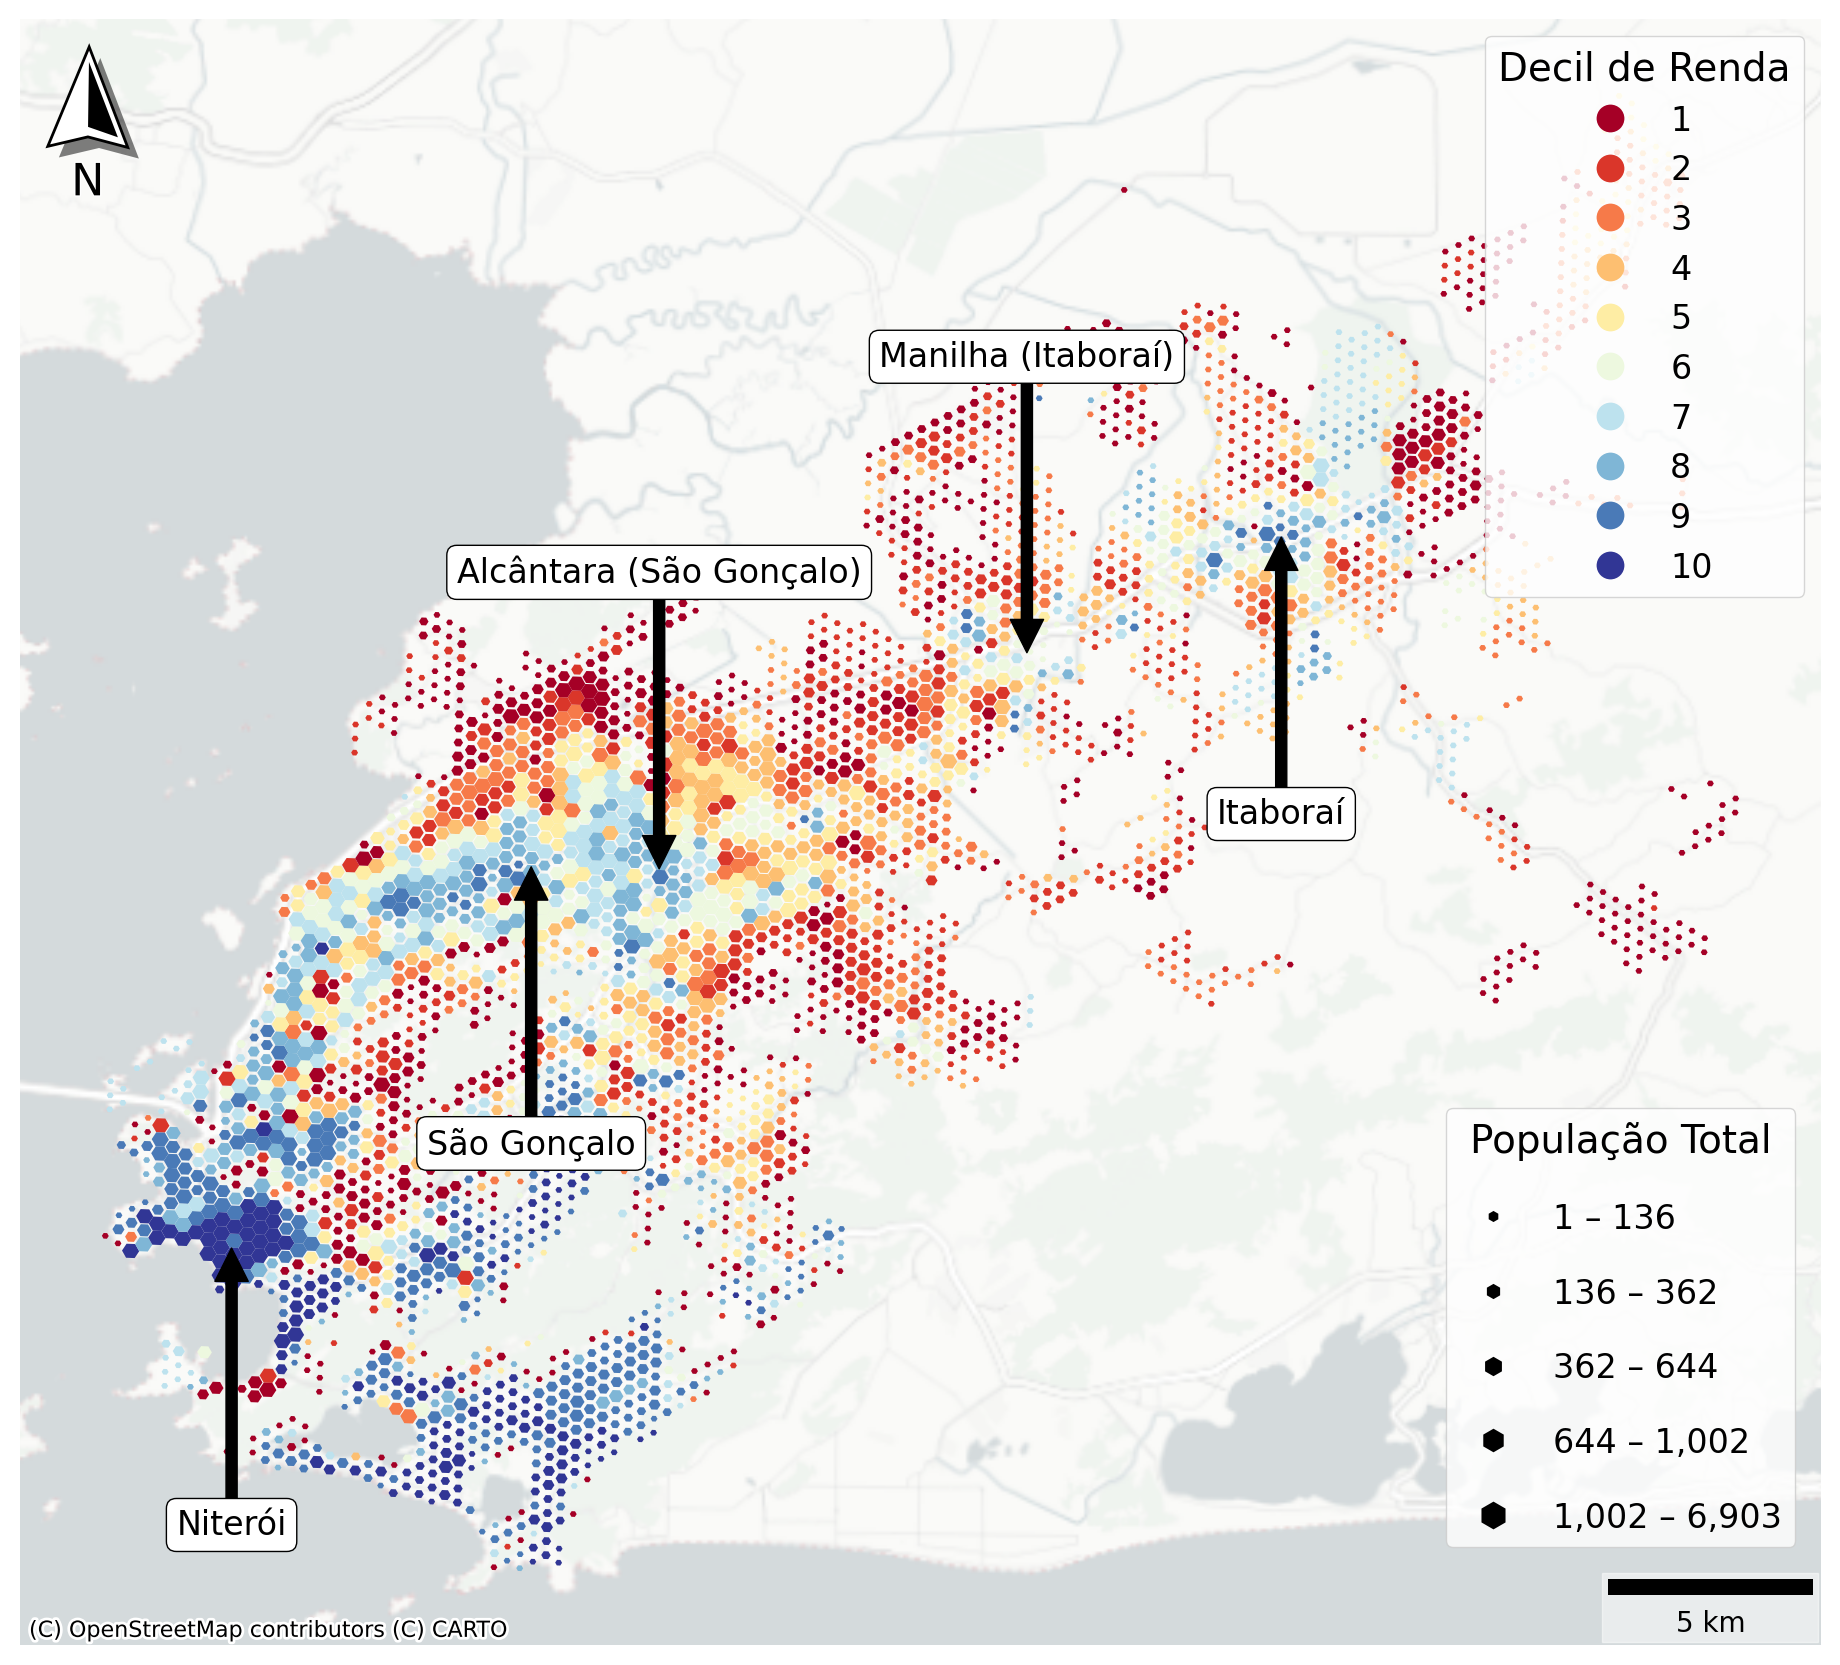

In [19]:
plot_socioeconomic_data(
    hexagons=hexes,
    income_col='rendimento_medio',
    population_column="habitantes",
    population_scheme="JenksCaspall",
    cmap="RdYlBu",
    output_file=outpath,
)

# Variação Populacional

In [ ]:
hexes = pd.concat([
    get_study_area(ibge_id, gcloud_id, year=y).assign(ano=y)
    for y
    in [2010, 2022]
])

Downloading: 100%|██████████|
Downloading: https://geoftp.ibge.gov.br/organizacao_do_territorio/tipologias_do_territorio/areas_urbanizadas_do_brasil/2019/Shapefile/AreasUrbanizadas2019_Brasil.zip
Downloading: 100%|██████████|
Downloading: https://geoftp.ibge.gov.br/organizacao_do_territorio/tipologias_do_territorio/areas_urbanizadas_do_brasil/2019/Shapefile/AreasUrbanizadas2019_Brasil.zip


In [ ]:
def compute_population_change(gdf, year_col='ano', pop_col='habitantes'):
    """
    Computes population change between two years for each hex when hex_id is the index.

    Parameters:
    - gdf: GeoDataFrame with index as hex_id, and columns for year and population.
    - year_col: Column name for year.
    - pop_col: Column name for population.

    Returns:
    - GeoDataFrame with population change and geometry per hex_id.
    """
    # Reset index to ensure hex_id is included in pivot
    gdf_reset = gdf.reset_index()

    # Pivot: rows = hex_id, columns = year, values = population
    pivot = gdf_reset.pivot_table(index=gdf.index.name, 
                                   columns=year_col, 
                                   values=pop_col)

    # Validate year count
    if pivot.shape[1] != 2:
        raise ValueError("Data must contain exactly two years for comparison.")
    
    # Compute signed difference
    years = sorted(pivot.columns)
    pivot['Variação Populacional'] = pivot[years[1]].sub(pivot[years[0]], fill_value=0)

    # Add back geometry
    geometry = gdf[~gdf.index.duplicated(keep='first')]['geometry']
    result = pivot[['Variação Populacional']].join(geometry)

    return gpd.GeoDataFrame(result, geometry='geometry').dropna()


In [ ]:
pop_delta = compute_population_change(hexes)

outpath = Path(
    f"../outputs/mapas/variacao_populacional.png"
    )

fig, ax = setup_plot(pop_delta)
pop_delta.plot(
    column='Variação Populacional',
    cmap='PiYG',
    scheme='StdMean',
    legend=True,
    edgecolor="none",
    ax=ax,
    legend_kwds={
        "fontsize": 12,
        "title": "Variação Populacional",
        "title_fontsize": 14,
        "frameon": True,  # Enable the frame
        "facecolor": "white",  # Set the frame background color to white
    }
)

add_basemap(ax, pop_delta)
north_arrow(
    ax, location="upper left", rotation={"crs": pop_delta.crs, "reference": "center"}
)
add_scalebar(ax)
add_annotations(ax)
finalize_plot(fig, ax, 600, output_file=outpath)

# Projeções da População

In [71]:
POP_PROJECTION_URL = (
    "https://ftp.ibge.gov.br/Projecao_da_Populacao/"
    "Projecao_da_Populacao_2024/"
    "projecoes_2024_tab3_grupos_etarios_especificos.xlsx"
)


def read_pop_projections() -> pd.DataFrame:
    """
    Download and process population projections data from IBGE.

    Returns:
        pd.DataFrame: A DataFrame with columns 'id_setor_censitario' and
                      'rendimento_medio'.
    """
    return pd.read_excel(
        POP_PROJECTION_URL,
        skiprows=6,
        usecols="A:G,N:P,Z:AB, AF:AH",
    )

In [90]:
def filter_states(df, siglas):
    siglas = [siglas] if isinstance(siglas, str) else siglas
    return df[df["SIGLA"].isin(siglas)].copy()


def filter_years(df, start=None, end=None):
    if start:
        df = df[df["ANO"] >= start]
    if end:
        df = df[df["ANO"] <= end]
    return df


def _has_digits(s):
    return bool(re.search(r"\d|POP", s))


def _ends_with_any(suffixes):
    return lambda s: any(s.endswith(sfx) for sfx in suffixes)


def _starts_with(prefix):
    return lambda s: s.startswith(prefix)


def select_columns(df, by_age=False, gender=False):
    cols = df.columns
    base = _has_digits if by_age else _starts_with("POP")
    suffixes = ["_M", "_H"] if gender else ["_T"]
    suffix = _ends_with_any(suffixes)
    return [col for col in cols if base(col) and suffix(col)]


def rename_columns(cols):
    gender_map = {"_H": "Homens", "_M": "Mulheres", "_T": "Total"}

    def rename(col):
        for sfx, g in gender_map.items():
            if col.endswith(sfx):
                base = col.removesuffix(sfx)
                return f"{base} • {g}" if re.search(r"\d", base) else g
        return col

    return {col: rename(col) for col in cols}


def reshape_for_plot(df, columns):
    labels = rename_columns(columns)
    melted = df.melt(
        id_vars=["ANO", "SIGLA"],
        value_vars=columns,
        var_name="Grupo",
        value_name="População"
    )
    melted["Grupo"] = melted["Grupo"].map(labels)
    melted["População"] = melted["População"] / 1_000  # scale to thousands
    return melted


def render_plot(plot_df, hue_order, title, height, out_path):
    """Render a high-quality plot for A4 PDF output."""
    a4_width = 11.7  # inches (landscape A4)
    dpi = 600

    plt.figure(figsize=(a4_width, height), dpi=dpi, constrained_layout=True)

    sns.set_context("talk", font_scale=1.2)

    sns.lineplot(
        data=plot_df,
        x="ANO",
        y="População",
        hue="Grupo",
        hue_order=hue_order,
        palette='Dark2',
    )
    plt.ylim(bottom=0, top=20_000)
    plt.xlim(plot_df["ANO"].min(), plot_df["ANO"].max())
    #plt.title(title, fontsize=18)
    plt.xlabel("Ano", fontsize=16)
    plt.ylabel("População (milhares)", fontsize=16)

    plt.legend(
        title="Grupo",
        bbox_to_anchor=(1, 1),
        loc="upper left",
        fontsize=14,
        title_fontsize=16
    )

    plt.grid(True)

    # Format Y-axis ticks with commas
    formatter = FuncFormatter(lambda x, _: f"{int(x):,}")
    plt.gca().yaxis.set_major_formatter(formatter)

    # Adjust tick width and length to make ticks less bold/prominent
    plt.tick_params(axis='both', which='major', width=1, length=5)

    # Set tick label size using tick_params
    plt.tick_params(axis='both', which='major', labelsize=14)

    if out_path is not None:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")

    plt.show()


def plot_population_trend(
    df,
    sigla="BR",
    by_age=False,
    gender=False,
    start=None,
    end=None,
    height=5,
    out_path=None
):
    df = filter_states(df, sigla)
    df = filter_years(df, start, end)

    columns = select_columns(df, by_age=by_age, gender=gender)
    if not columns:
        print("No matching columns found.")
        return

    plot_df = reshape_for_plot(df, columns)
    hue_order = sorted(plot_df["Grupo"].unique())

    title = "Projeção Populacional"
    if isinstance(sigla, list):
        title += f" ({', '.join(sigla)})"
    else:
        title += f" – {sigla}"

    disagg = ", ".join(filter(None, [
        "Por Faixa Etária" if by_age else "",
        "Por Gênero" if gender else ""
    ]))
    if disagg:
        title += f" ({disagg})"

    if out_path is not None:
        filepath = Path(out_path) / f"projecao_genero-{gender}_idade-{by_age}.png"
    render_plot(plot_df, hue_order, title, height, out_path=filepath)

In [91]:
plot_population_trend(
    read_pop_projections(),
    sigla="RJ",
    by_age=True,
    #gender=True,
    out_path="../outputs/mapas",
)

# Exercício: Mapas Coropléticos

Objetivo: Compreender os princípios básicos do mapeamento coroplético e aplicar técnicas de classificação e escolha de cores para representar dados espaciais.

Contexto:

Mapas coropléticos são representações cartográficas que utilizam variações de cor para mostrar valores estatísticos agregados por regiões (como estados, municípios ou bairros). Cada região é associada a um valor e preenchida com uma cor que corresponde à sua classe de valor. Embora hoje seja possível criar mapas sem classificação (unclassed), a abordagem com classes (classed) continua sendo valiosa por facilitar a interpretação visual dos dados.

Três decisões fundamentais no mapeamento coroplético:
- Número de classes: Definir em quantos grupos os valores serão divididos.
- Método de classificação: Escolher o algoritmo para agrupar os dados (ex: quantis, intervalos iguais, Jenks).
- Escolha das cores: Aplicar uma paleta que represente adequadamente as diferenças entre os grupos.

Você deve explorar esses conceitos e, para isso, irá utilizar bibliotecas Python como geopandas e [pacotes do conjunto de bibliotecas PySAL](https://pysal.org/). Acompanhe o capítulo Choropleth Mapping do livro [Geographic Data Science with Python](https://geographicdata.science/book/notebooks/05_choropleth.html) e reproduza o exercício prático lá contido com os municípios acima. Documente o passo a passo e discuta e analise seus achados.